In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import seaborn as sns
import scipy

import preprocess as pp

## TODO:

1. outlier detection -- z score?
2. better signal extraction

In [2]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
# rc('text', usetex=True)

In [3]:
test_video = 'data/marker_raw_480x480_30fps.mp4'
if not os.path.isfile(test_video): raise Exception('invalid video path')

In [4]:
# preprocess
stabilized_array = pp.preprocess(
    test_video,
    output='array',
    smoothing_window=5,
)
print(stabilized_array.shape)

stabilizing output


  0%|          | 0/1415 [00:00<?, ?it/s]

100%|█████████▉| 1414/1415 [00:22<00:00, 63.89it/s]


smoothing output
(1414, 480, 480, 3)


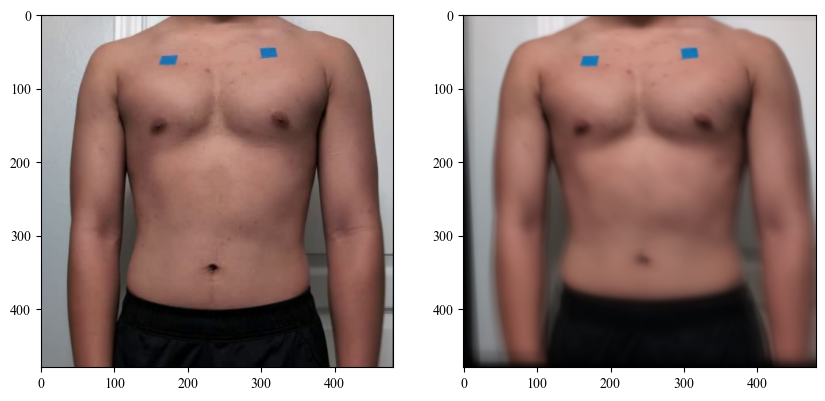

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(cv2.cvtColor(stabilized_array[0], cv2.COLOR_BGR2RGB))
ax[1].imshow(pp.smear(stabilized_array))

In [6]:
test_array = stabilized_array
cv_channels = {'b': 0, 'g': 1, 'r': 2}
test_array_green = test_array[:, :, :, cv_channels['g']]
test_array_red = test_array[:, :, :, cv_channels['r']]
test_array_blue = test_array[:, :, :, cv_channels['b']]
print(test_array_green.shape)

(1414, 480, 480)


(576, 1414)


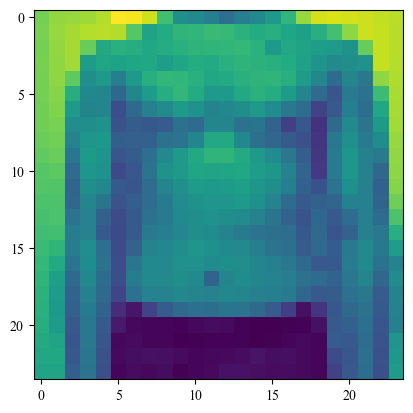

In [50]:
block_size = 20

n_frames = test_array_green.shape[0]
green_signals = pp.resize_func(np.mean, test_array_green, block_size).reshape(n_frames, -1).swapaxes(0, 1)
red_signals = pp.resize_func(np.mean, test_array_red, block_size).reshape(n_frames, -1).swapaxes(0, 1)
blue_signals = pp.resize_func(np.mean, test_array_blue, block_size).reshape(n_frames, -1).swapaxes(0, 1)
print(green_signals.shape)

plt.figure()
plt.imshow(pp.resize_func(np.mean, test_array_green, block_size)[0], cmap='viridis')
plt.show()

In [51]:
def chrom(r, g, b, fps, fft=False):

    rgb_mean = (r + g + b) / 3
    Rn, Gn, Bn = r/rgb_mean, g/rgb_mean, b/rgb_mean

    Xs = 3*Rn - 2*Gn
    Ys = 1.5*Rn + Gn - 1.5*Bn

    low_freq = 40/60
    high_freq = 240/60

    iirb, iira = scipy.signal.butter(3, ((2*low_freq)/fps, (2*high_freq)/fps), 'bandpass')

    Xf = scipy.signal.filtfilt(iirb, iira, Xs)
    Yf = scipy.signal.filtfilt(iirb, iira, Ys)

    alpha = np.std(Xf) / np.std(Yf)
    S = Xf - alpha*Yf
    
    if fft:
        S_fft = np.abs(np.fft.rfft(S))
        return S_fft
    else:
        return S

In [52]:
def score_fft(sigfft, fps, k=1):
    
    topk = np.argsort(sigfft)[-k:][::-1]

    return sigfft[topk], topk*60/fps

In [104]:
def fit_chrom(r, g, b, fps=30):
    return score_fft(chrom(r, g, b, fps, fft=True), fps, 1)

In [105]:
def fit(reds, greens, blues, fit_func, fps=30):
    bpm, bpm_vals = [], []
    for i, (r, g, b) in enumerate(zip(red_signals, green_signals, blue_signals)):
        (topk_val,), (topk_bpm,) = fit_func(r, g, b, fps)
        bpm.append(topk_bpm)
        bpm_vals.append(topk_val)
    bpm = np.array(bpm)
    bpm[bpm > 200] = 0

    return bpm

In [106]:
def score(bpms, resolution=480):
    bpm_2d = bpms.reshape(resolution//block_size, -1)
    print(f'generated results of shape {bpm_2d.shape}')
    bpm_mean = np.mean(bpm_2d)
    bpm_std = np.std(bpm_2d)
    bpm_zscore = (bpm_2d - bpm_mean)/bpm_std
    print(f'bpm mean: {bpm_mean}, bpm std: {bpm_std}')

    

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].imshow(test_array[0][:,:,[2,1,0]])
    bound = 1
    im = ax[0].imshow(bpm_zscore, 
                      cmap='RdBu', 
                      alpha=0.5, 
                      extent=[0, resolution, 0, resolution], 
                      aspect='auto', 
                      vmin=-bound, vmax=bound)
    fig.colorbar(im, ax=ax[0])
    ax[0].set_ylim(resolution, 0)
    ax[0].set(aspect='equal')

    sns.histplot(bpms, bins=30, kde=True, ax=ax[1])


C:\Users\Tienda\AppData\Local\Temp\ipykernel_27224\1828222693.py:4: RuntimeWarning: invalid value encountered in divide
  Rn, Gn, Bn = r/rgb_mean, g/rgb_mean, b/rgb_mean
c:\Users\Tienda\miniconda3\envs\chest-rppg\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


generated results of shape (24, 24)
bpm mean: 88.66666666666667, bpm std: 26.67786223319502


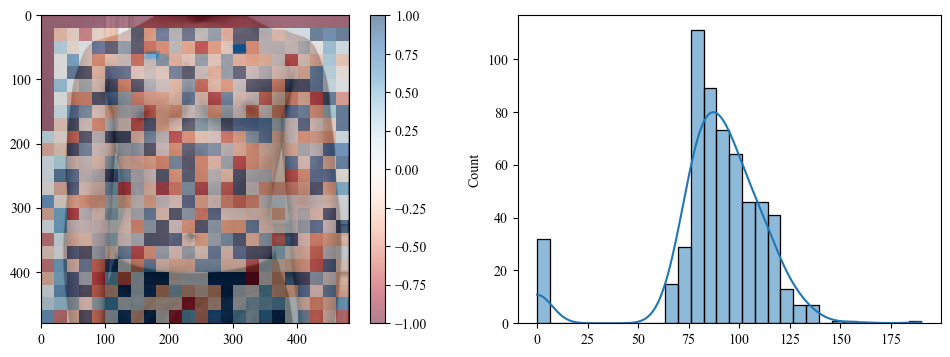

In [108]:
bpm_chrom = fit(red_signals, green_signals, blue_signals, fit_chrom)
score(bpm_chrom)